In [24]:
%run talktools.py

###  Sao Paulo School of Advanced Science on Learning from Data , July 31 - Aug 2, 2019
### Big Data Sets in Astronomy, Zeljko Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/SPSAS2019/Day2.ipynb


# Day 2:  Density Estimation, Clustering and Classification in Astronomy

Below "textbook" refers to Statistics, Data Mining, and Machine Learning in Astronomy by Zeljko Ivezic, Andrew Connolly, Jacob VanderPlas, and Alex Gray, published by Princeton University Press
https://press.princeton.edu/titles/10159.html



##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapters 4, 5, 6 and 9.  
- [Connolly, Ivezic and Juric notebooks from various UW classes](https://github.com/dirac-institute/uw-astr598-w18)
- [Gordon Richard's class notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: ``Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: ``Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: ``Data Analysis: A Bayesian Tutorial''](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: ``Probability Theory: The Logic of Science''](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)


In [25]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
%matplotlib inline

To warm up, let's make a very simple one-dimensional dataset by drawing 
200 values from a normal distribution N(100,15), which approximately 
describes the human IQ (intelligence quotient) distribution. 

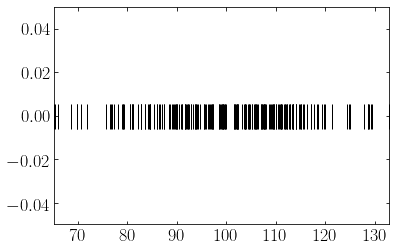

In [26]:
Nstudents = 200
IQmean = 100
IQstd = 15
xIQ = norm(IQmean, IQstd).rvs(Nstudents)
plt.plot(xIQ, 0*xIQ, '|', color='k', markersize=25) # N.B. markersize is in *points*

Given these 200 IQ measurements, and our **belief** that the data were "drawn" from a normal (Gaussian) distribution, how do we estimate the mean IQ and its standard deviation (scatter around the mean value)? 

### Uncertainty for the mean and the sample standard deviation

We would also like to know the uncertainty of our estimates $\overline{x}$ and $s$.  Note that $s$ is **NOT** the uncertainty of $\overline{x}$.  Rather the uncertainty of $\overline{x}$, $\sigma_{\overline{x}}$ is 
$$ \sigma_{\overline{x}} = \frac{s}{\sqrt{N}},$$
which we call the *standard error of the mean*.

The uncertainty of $s$ itself is
$$\sigma_s = \frac{s}{\sqrt{2(N-1)}} = \frac{1}{\sqrt{2}}\sqrt{\frac{N}{N-1}}\sigma_{\overline{x}}.$$

Note that for large $N$, $\sigma_{\overline{x}} \sim \sqrt{2}\sigma_s$ and for small $N$, $\sigma_s$ is not much smaller than $s$.

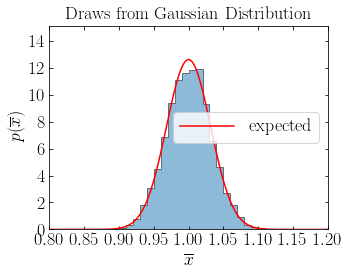

In [27]:
### let's see how it looks in practice by doing a few numerical experiments
# 1) draw k=10 numbers from N(mu=1.0, sigma=0.1) and compute their mean; repeat this 
#   computation M=10,000 times and plot the distribution of these M means; is this
#   distribution well described by N(1.0, 0.1/sqrt(k))? 
np.random.seed(42)
k = 10
M = 10000
mu = 1.0
sigma = 0.1
means = np.zeros(M)  # for storing the mean values obtained in M draws
for i in range(M):
    x = norm(mu, sigma).rvs(k) # here we draw k numbers from N(mu=1.0, sigma=0.1)
    means[i] = np.mean(x)
## now plot the histogram of values in array means
fig, ax = plt.subplots(figsize=(5, 3.75))
# histogram the data
ax.hist(means, bins=np.linspace(0.8, 1.2, 41),
            histtype='stepfilled', alpha=0.5, normed=True)
# expected gaussian distribution
xGrid = np.linspace(0, 2, 1000)
gauss = norm(mu, sigma/np.sqrt(k)).pdf(xGrid)  # this is a function of x: gauss(x)
plt.plot(xGrid, gauss, ls='-', c='red', label='expected')

plt.xlim(0.8, 1.2)
yMax = 1.2*np.sqrt(k)/np.sqrt(2*3.14) / sigma 
plt.ylim(0, yMax)
plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
plt.title('Draws from Gaussian Distribution')
plt.legend()
plt.show()

st.dev.= 0.1002614444802871


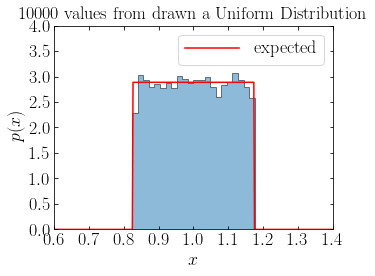

In [28]:
### what if we don't draw from a gaussian distribution, but instead from a uniform distribution?
# 2) draw k=10 numbers from a uniform distribution U(mu=1.0, W) and compute their mean; repeat this 
#    computation M=1000 times and plot the distribution of these M means; is this
#    distribution well described by N(1.0, 0.1/sqrt(k))? 
# let's first see one (largish) sample drawn from uniform distribution
k = 10
M = 10000
mu = 1.0
sigma = 0.1
W = sigma*np.sqrt(12.0)  # same standard deviation as for gaussian
left = mu - 0.5 * W    
x = uniform(left, W).rvs(10000) # here we draw 10000 numbers between 0.8268 and 1.1732
print 'st.dev.=',np.std(x)
# now plot the histogram of values in array means
fig, ax = plt.subplots(figsize=(5, 3.75))
# histogram the data
ax.hist(x, bins=np.linspace(0.6, 1.4, 51),
            histtype='stepfilled', alpha=0.5, normed=True)
# expected uniform distribution
xGrid = np.linspace(0, 2, 1000)
flat = uniform(left,W).pdf(xGrid)  # this is a function of x: gauss(x)
plt.plot(xGrid, flat, ls='-', c='red', label='expected')
plt.xlim(0.6, 1.4)
plt.ylim(0, 4)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('10000 values from drawn a Uniform Distribution')
plt.legend()
plt.show()

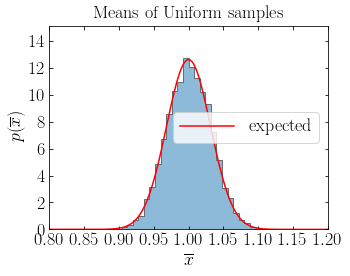

In [29]:
### what if we don't draw from a gaussian distribution, but instead from a uniform distribution?
# 2) draw k=10 numbers from a uniform distribution U(mu=1.0, W) and compute their mean; repeat this 
#    computation M=1000 times and plot the distribution of these M means; is this
#    distribution well described by N(1.0, 0.1/sqrt(k))? 
means = np.zeros(M)  # for storing the mean values obtained in M draws
for i in range(M):
    x = uniform(left, W).rvs(k) # here we draw k numbers between 0.8268 and 1.1732  
    means[i] = np.mean(x)
# now plot the histogram of values in array means
fig, ax = plt.subplots(figsize=(5, 3.75))
# histogram the data
ax.hist(means, bins=np.linspace(0.8, 1.2, 51),
            histtype='stepfilled', alpha=0.5, normed=True)
# expected gaussian distribution
x = np.linspace(0, 2, 1000)
gauss = norm(mu, sigma/np.sqrt(k)).pdf(x)  # this is a function of x: gauss(x)
plt.plot(x, gauss, ls='-', c='red', label='expected')
plt.xlim(0.8, 1.2)
yMax = 1.2*np.sqrt(k)/np.sqrt(2*3.14) / sigma 
plt.ylim(0, yMax)
plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
plt.title('Means of Uniform samples')
plt.legend()
plt.show()

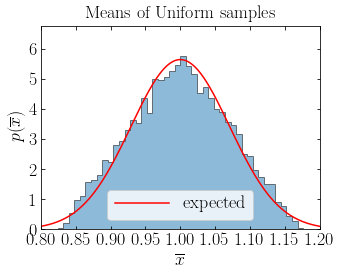

In [30]:
### this is becoming interesting: it looks like it doesn't matter from which 
### distribution we draw our sample! Does it depend on the sample size? 
# 3) draw now k=2 numbers from U(mu=1.0, W=2.0) 
k = 2
means = np.zeros(M)  # for storing the mean values obtained in M draws
for i in range(M):
    x = uniform(left, W).rvs(k) # here we draw k numbers between 0.8268 and 1.1732  
    means[i] = np.mean(x)
# now plot the histogram of values in array means
fig, ax = plt.subplots(figsize=(5, 3.75))
# histogram the data
ax.hist(means, bins=np.linspace(0.8, 1.2, 51),
            histtype='stepfilled', alpha=0.5, normed=True)
# expected gaussian distribution
x = np.linspace(0, 2, 1000)
gauss = norm(mu, sigma/np.sqrt(k)).pdf(x)  # this is a function of x: gauss(x)
plt.plot(x, gauss, ls='-', c='red', label='expected')
plt.xlim(0.8, 1.2)
yMax = 1.2*np.sqrt(k)/np.sqrt(2*3.14) / sigma 
plt.ylim(0, yMax)
plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
plt.title('Means of Uniform samples')
plt.legend()
plt.show()

Now it is not such a good agreement any more!!

The blue histogram seems limited to the range from 0.83 to 1.17, why? 

![SlideGrab](figures/p6.pdf) 

![SlideGrab](figures/p7.pdf) 

![SlideGrab](figures/p22.pdf) 

While it is perhaps most common to compute the mean, the median is a more *robust* estimator of the (true) mean location of the distribution.  That's because it is less affected by outliers.

In [31]:
# Execute this cell.  Think about what it is doing.
data = norm(0.5, 0.1).rvs(10000)
mean = np.mean(data)
median = np.median(data)
stdev = np.std(data)
mask = data>0.7
print 'the number of modified points:', np.sum(mask)
data[mask] = data[mask]*10
newmean = np.mean(data)
newmedian = np.median(data)
newstdev = np.std(data)
print 'mean:', mean, newmean
print 'median:', median, newmedian
print 'st.dev.:', stdev, newstdev

the number of modified points: 220
mean: 0.49858369570686245 0.6447025731415361
median: 0.49988324982565974 0.49988324982565974
st.dev.: 0.10046712323531173 1.0158028625919946


Percentiles, $q_p$, are computed as
$$\frac{p}{100} = \int_{-\infty}^{q_p}h(x) dx$$

For example, the 25th, 50th, and 75th percentiles:

In [32]:
# execute:
mu=100
sigma=15
sampleSize=1000000    # IQ distribution in Seattle
data = norm(mu, sigma).rvs(sampleSize) 
q25 = np.percentile(data, 25)
q50 = np.percentile(data, 50)
q75 = np.percentile(data, 75)
mean = np.mean(data)
print mean, q25, q50, q75 

99.98052867967623 89.84040081404993 99.99103263589001 110.1106062085681


In [33]:
# execute:
%timeit mean = np.mean(data)
%timeit median = np.median(data)

1000 loops, best of 3: 490 µs per loop
100 loops, best of 3: 13.7 ms per loop


The difference between the 25th and 75th percentiles, $q_{75} - q_{25}$, is called the *interquartile range*.

The median and interquartile range are more _robust_ estimators of the location and scale parameters 
than the mean and standard deviation.  So, one can create a robust standard deviation like estimator,
from the interquartile range as
$$\sigma_G = 0.7413(q_{75} - q_{25}).$$

The normalization (0.7413) makes it *unbiased* estimator of standard deviation in case of a Gaussian.

![SlideGrab](figures/p24.pdf)  

In [34]:
# execute
%timeit sigmaG = astroMLstats.sigmaG(data)
%timeit stdev = np.std(data)

100 loops, best of 3: 14.5 ms per loop
100 loops, best of 3: 2.06 ms per loop


In [35]:
# execute
print astroMLstats.sigmaG(data), np.std(data)

15.026325743738433 15.013221697152268


## Distributions

If we are attempting to characterize our data in a way that is **parameterized**, then we need a functional form or a **distribution**.  There are many naturally occurring distributions.  The book goes through quite a few of them.  Here we'll just talk about a few basic ones to get us started.


### Uniform Distribution

The uniform distribution is perhaps more commonly called a "top-hat" or a "box" distribution.  It is specified by a mean, $\mu$, and a width, $W$, where

$$p(x|\mu,W) = \frac{1}{W}$$

over the range $|x-\mu|\le \frac{W}{2}$ and $0$ otherwise.  That says that "given $\mu$ AND $W$, the probability of $x$ is $\frac{1}{W}$" (as long as we are within a certain range).

Since we are used to thinking of a Gaussian as the *only* type of distribution the concept of $\sigma$ (aside from the width) may seem strange.  But $\sigma$ as mathematically defined above applies here and
$$\sigma = \frac{W}{\sqrt{12}}.$$


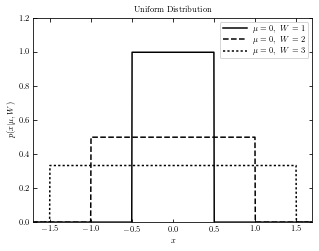

In [36]:
# Execute this cell
%matplotlib inline
%run code/fig_uniform_distribution.py

### $\chi^2$ Distribution

We'll run into the $\chi^2$ distribution when we talk about Maximum Likelihood in the next chapter.

If we have a Gaussian distribution with values ${x_i}$ and we scale and normalize them according to
$$z_i = \frac{x_i-\mu}{\sigma},$$
then the sum of squares, $Q$ 
$$Q = \sum_{i=1}^N z_i^2,$$
will follow the $\chi^2$ distribution.  The *number of degrees of freedom*, $k$ is given by the number of data points, $N$ (minus any constraints).  The pdf of $Q$ given $k$ defines $\chi^2$ and is given by
$$p(Q|k)\equiv \chi^2(Q|k) = \frac{1}{2^{k/2}\Gamma(k/2)}Q^{k/2-1}\exp(-Q/2),$$
where $Q>0$ and the $\Gamma$ function would just be the usual factorial function if we were dealing with integers, but here we have half integers.

This is ugly, but it is really just a formula like anything else.  Note that the shape of the distribution *only* depends on the sample size $N=k$ and not on $\mu$ or $\sigma$.  

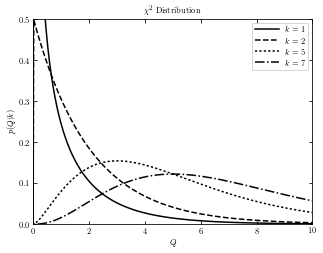

In [37]:
# Execute this cell
%run code/fig_chi2_distribution.py

![SlideGrab](figures/p18.pdf) 

![SlideGrab](figures/p19.pdf) 

![SlideGrab](figures/p20.pdf) 

![SlideGrab](figures/p25.pdf) 

## Bivariate and Multivariate Distribution Functions

Up to now we have been dealing with one-dimensional distribution functions.  Let's now consider a two dimensional distribution $h(x,y)$ where $$\int_{-\infty}^{\infty}dx\int_{-\infty}^{\infty}h(x,y)dy = 1.$$  $h(x,y)$ is telling us the probability that $x$ is between $x$ and $dx$ and *also* that $y$ is between $y$ and $dy$.

Then we have the following definitions:

$$\sigma^2_x = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(x-\mu_x)^2 h(x,y) dx dy$$

$$\sigma^2_y = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(y-\mu_y)^2 h(x,y) dx dy$$

$$\mu_x = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}x h(x,y) dx dy$$

$$\sigma_{xy} = Cov(x,y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}(x-\mu_x) (y-\mu_y) h(x,y) dx dy$$

If $x$ and $y$ are uncorrelated, then we can treat the system as two independent 1-D distributions.  This means that choosing a range on one variable has no effect on the distribution of the other.

We can write a 2-D Gaussian pdf as
$$p(x,y|\mu_x,\mu_y,\sigma_x,\sigma_y,\sigma_{xy}) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \exp\left(\frac{-z^2}{2(1-\rho^2)}\right),$$

where $$z^2 = \frac{(x-\mu_x)^2}{\sigma_x^2} + \frac{(y-\mu_y)^2}{\sigma_y^2} - 2\rho\frac{(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y},$$

with $$\rho = \frac{\sigma_{xy}}{\sigma_x\sigma_y}$$
as the (dimensionless) correlation coefficient.

If $x$ and $y$ are perfectly correlated then $\rho=\pm1$ and if they are uncorrelated, then $\rho=0$.

The pdf is now not a histogram, but rather a series of contours in the $x-y$ plane.   These are centered at $(x=\mu_x, y=\mu_y)$ and are tilted at angle $\alpha$, which is given by
$$\tan(2 \alpha) = 2\rho\frac{\sigma_x\sigma_y}{\sigma_x^2-\sigma_y^2} = 2\frac{\sigma_{xy}}{\sigma_x^2-\sigma_y^2}.$$

For example (Figure 3.22 from the textbook):
![Figure 3.22](http://www.astroml.org/_images/fig_bivariate_gaussian_1.png)

We can define new coordinate axes that are aligned with the minimum and maximum widths of the distribution.  These are called the **principal axes** and are given by
$$P_1 = (x-\mu_x)\cos\alpha + (y-\mu_y)\sin\alpha,$$
and
$$P_2 = -(x-\mu_x)\sin\alpha + (y-\mu_y)\cos\alpha.$$

The widths in this coordinate system are
$$\sigma^2_{1,2} = \frac{\sigma_x^2+\sigma_y^2}{2}\pm\sqrt{\left(\frac{\sigma_x^2-\sigma_y^2}{2}\right)^2 + \sigma^2_{xy}}.$$

Note that the correlation vanishes in this coordinate system and the bivariate Gaussian is just a product of two univariate Gaussians.  This concept will be crucial for understanding Principal Component Analysis when we get to Day 3, where PCA extends this idea to even more dimensions.

In the univariate case we used $\overline{x}$ and $s$ to *estimate* $\mu$ and $\sigma$.  In the bivariate case we estimate 5 parameters: $(\overline{x},\overline{y},s_x,s_y,s_{xy})$.  

As with the univariate case, it is important to realize that outliers can bias these estimates and that it may be more appropriate to use the median rather than the mean as a more robust estimator for $\mu_x$ and $\mu_y$.  

Similarly we want robust estimators for the other parameters of the fit.   
![Ivezic, Figure 3.23](http://www.astroml.org/_images/fig_robust_pca_1.png)

For an example of how to generate a bivariate distribution and plot confidence contours, execute the following cell.

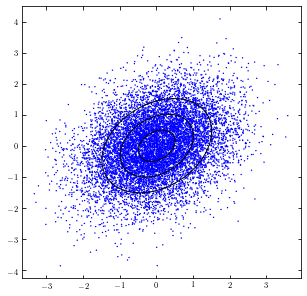

In [38]:
# Base code drawn from the textbook, Figure 3.22, edited by G. Richards to simplify the example
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal
from astroML.stats import fit_bivariate_normal

#------------------------------------------------------------
# Create 10,000 points from a multivariate normal distribution
mean = [0, 0]
cov = [[1, 0.3], [0.3, 1]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T

# Fit those data with a bivariate normal distribution
mean, sigma_x, sigma_y, alpha = fit_bivariate_normal(x,y)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plt.scatter(x,y,s=2,edgecolor='none')

# draw 1, 2, 3-sigma ellipses over the distribution
for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean, N * sigma_x, N * sigma_y, angle=alpha * 180./np.pi, lw=1, ec='k', fc='none'))

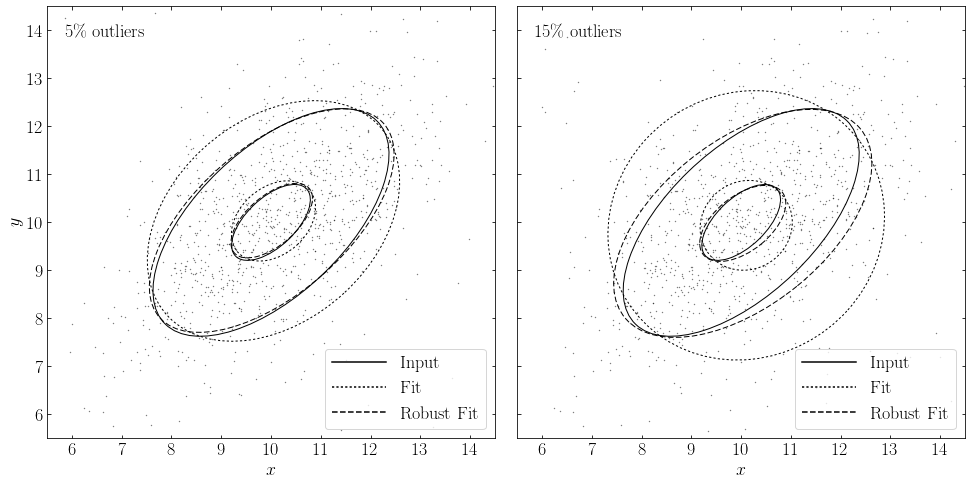

In [39]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal
from astroML.stats.random import bivariate_normal

# percent sign needs to be escaped if usetex is activated
import matplotlib
if matplotlib.rcParams.get('text.usetex'):
    pct = r'\%'
else:
    pct = r'%'

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

N = 1000

sigma1 = 2.0
sigma2 = 1.0
mu = [10, 10]
alpha_deg = 45.0
alpha = alpha_deg * np.pi / 180

#------------------------------------------------------------
# Draw N points from a multivariate normal distribution
#
#   we use the bivariate_normal function from astroML.  A more
#   general function for this is numpy.random.multivariate_normal(),
#   which requires the user to specify the full covariance matrix.
#   bivariate_normal() generates this covariance matrix for the
#   given inputs

np.random.seed(0)
X = bivariate_normal(mu, sigma1, sigma2, alpha, N)

#------------------------------------------------------------
# Create the figure showing the fits
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.05,
                    bottom=0.15, top=0.95)


# We'll create two figures, with two levels of contamination
for i, f in enumerate([0.05, 0.15]):
    ax = fig.add_subplot(1, 2, i + 1)

    # add outliers distributed using a bivariate normal.
    X[:int(f * N)] = bivariate_normal((10, 10), 2, 4,
                                      45 * np.pi / 180., int(f * N))
    x, y = X.T

    # compute the non-robust statistics
    (mu_nr, sigma1_nr,
     sigma2_nr, alpha_nr) = fit_bivariate_normal(x, y, robust=False)

    # compute the robust statistics
    (mu_r, sigma1_r,
     sigma2_r, alpha_r) = fit_bivariate_normal(x, y, robust=True)

    # scatter the points
    ax.scatter(x, y, s=2, lw=0, c='k', alpha=0.5)

    # Draw elipses showing the fits
    for Nsig in [1, 3]:
        # True fit
        E = Ellipse((10, 10), sigma1 * Nsig, sigma2 * Nsig, alpha_deg,
                    ec='k', fc='none')
        ax.add_patch(E)

        # Non-robust fit
        E = Ellipse(mu_nr, sigma1_nr * Nsig, sigma2_nr * Nsig,
                    (alpha_nr * 180. / np.pi),
                    ec='k', fc='none', linestyle='dotted')
        ax.add_patch(E)

        # Robust fit
        E = Ellipse(mu_r, sigma1_r * Nsig, sigma2_r * Nsig,
                    (alpha_r * 180. / np.pi),
                    ec='k', fc='none', linestyle='dashed')
        ax.add_patch(E)

    ax.text(0.04, 0.96, '%i%s outliers' % (f * 100, pct),
            ha='left', va='top', transform=ax.transAxes)

    ax.set_xlim(5.5, 14.5)
    ax.set_ylim(5.5, 14.5)
    ax.set_xlabel('$x$')

    # This is a bit of a hack:
    # We'll draw some lines off the picture to make our legend look better
    ax.plot([0], [0], '-k', label='Input')
    ax.plot([0], [0], ':k', label='Fit')
    ax.plot([0], [0], '--k', label='Robust Fit')
    ax.legend(loc='lower right')

    if i == 0:
        ax.set_ylabel('$y$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

plt.show()

![SlideGrab](figures/p27.pdf) 

![SlideGrab](figures/p28.pdf) 

![SlideGrab](figures/p29.pdf) 

![SlideGrab](figures/p30.pdf) 

![SlideGrab](figures/p31.pdf) 

![SlideGrab](figures/p32.pdf) 

(array([ 8.,  8., 22., 29., 32., 30., 42., 18.,  4.,  7.]),
 array([ 65.2934033 ,  72.23188157,  79.17035984,  86.1088381 ,
         93.04731637,  99.98579464, 106.9242729 , 113.86275117,
        120.80122944, 127.73970771, 134.67818597]),
 <a list of 1 Patch objects>)

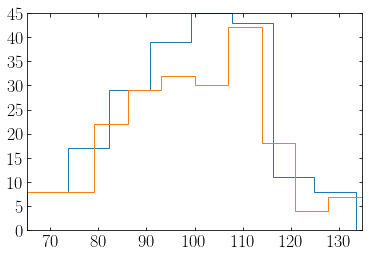

In [40]:
from astroML.plotting import hist as fancyhist
fancyhist(xIQ, bins="scott", histtype="step")
fancyhist(xIQ, bins="freedman", histtype="step")

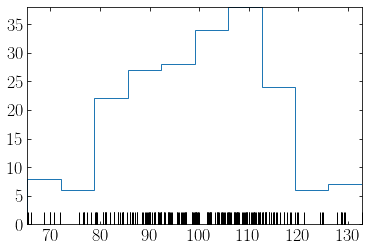

In [41]:
plt.hist(xIQ,histtype="step")
plt.plot(xIQ, 0*xIQ, '|', color='k', markersize=25) # N.B. markersize is in *points*

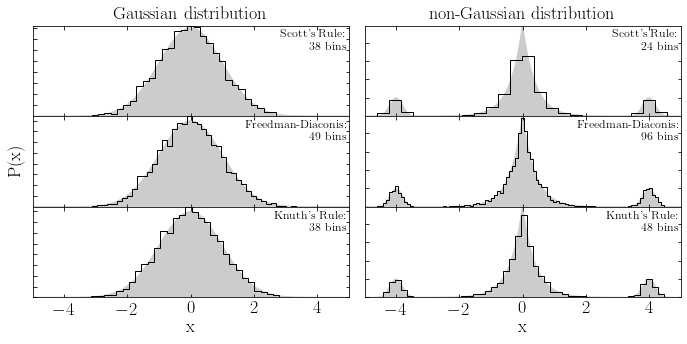

In [42]:
# plot fig. 5.20 from the textbook
%run ../aMLpy/fig_hist_binsize.py 

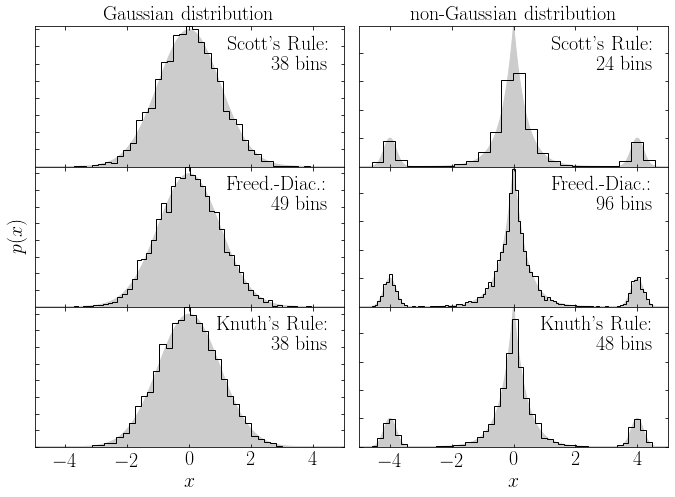

In [43]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.plotting import hist as astroMLhist

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)


def plot_labeled_histogram(style, data, name,
                           x, pdf_true, ax=None,
                           hide_x=False,
                           hide_y=False):
    if ax is not None:
        ax = plt.axes(ax)

    counts, bins, patches = astroMLhist(data, bins=style, ax=ax,
                                 color='k', histtype='step', normed=True)
    ax.text(0.95, 0.93, '%s:\n%i bins' % (name, len(counts)),
            transform=ax.transAxes,
            ha='right', va='top')

    ax.fill(x, pdf_true, '-', color='#CCCCCC', zorder=0)

    if hide_x:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if hide_y:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(-5, 5)

    return ax


#------------------------------------------------------------
# Set up distributions:
Npts = 5000
np.random.seed(0)
x = np.linspace(-6, 6, 1000)

# Gaussian distribution
data_G = stats.norm(0, 1).rvs(Npts)
pdf_G = stats.norm(0, 1).pdf(x)

# Non-Gaussian distribution
distributions = [stats.laplace(0, 0.4),
                 stats.norm(-4.0, 0.2),
                 stats.norm(4.0, 0.2)]

weights = np.array([0.8, 0.1, 0.1])
weights /= weights.sum()

data_NG = np.hstack(d.rvs(int(w * Npts))
                    for (d, w) in zip(distributions, weights))
pdf_NG = sum(w * d.pdf(x)
             for (d, w) in zip(distributions, weights))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
ax = [fig.add_subplot(3, 2, i + 1) for i in range(6)]

# first column: Gaussian distribution
plot_labeled_histogram('scotts', data_G, 'Scott\'s Rule', x, pdf_G,
                       ax=ax[0], hide_x=True, hide_y=True)
plot_labeled_histogram('freedman', data_G, 'Freed.-Diac.', x, pdf_G,
                       ax=ax[2], hide_x=True, hide_y=True)
plot_labeled_histogram('knuth', data_G, 'Knuth\'s Rule', x, pdf_G,
                       ax=ax[4], hide_x=False, hide_y=True)

ax[0].set_title('Gaussian distribution')
ax[2].set_ylabel('$p(x)$')
ax[4].set_xlabel('$x$')

# second column: non-gaussian distribution
plot_labeled_histogram('scotts', data_NG, 'Scott\'s Rule', x, pdf_NG,
                       ax=ax[1], hide_x=True, hide_y=True)
plot_labeled_histogram('freedman', data_NG, 'Freed.-Diac.', x, pdf_NG,
                       ax=ax[3], hide_x=True, hide_y=True)
plot_labeled_histogram('knuth', data_NG, 'Knuth\'s Rule', x, pdf_NG,
                       ax=ax[5], hide_x=False, hide_y=True)

ax[1].set_title('non-Gaussian distribution')
ax[5].set_xlabel('$x$')

plt.show()

### Bayesian Blocks algorithm
Though Knuth’s Bayesian method for choosing histogram bin width is 
an improvement over the Scott’s rule and the Freedman–Diaconis rule, 
it still has a distinct weakness: it assumes a **uniform** width for 
the optimal histogram bins.  

This limitation can be lifted by maximizing a well-designed likelihood function over bins of varying width. This approach has been dubbed Bayesian blocks. The method was first developed in the field of 
time-domain analysis, but is readily applicable to histogram data as well. 

Bayesian Blocks method gives you the best step function that describes your data. 
It is excellent for low-count data and for time-series analysis!

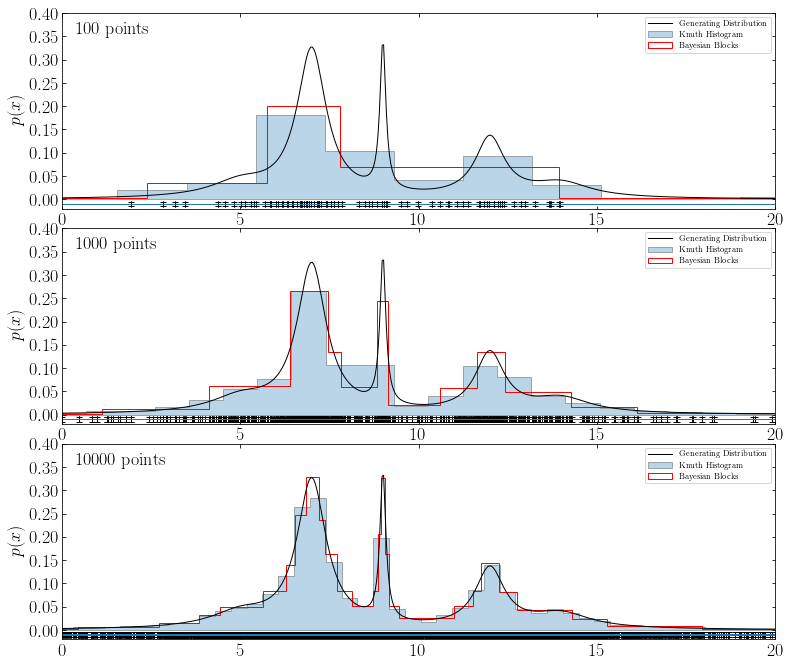

In [44]:
# Generate sample: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)
# plot the results
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (100, 1000, 10000)
subplots = (311, 312, 313)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.errorbar(xN, -0.01 + 0*xN, xerr=0.0, yerr=0.005, ecolor='black', lw=1)
    ax.plot(t, true_pdf(t), '-', color='black', lw=1,
            label="Generating Distribution")
    hist(xN, bins='knuth', ax=ax, normed=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, normed=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=8))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.02, 0.4001)

plt.show()




 ### Note
For largest sample (N=10,000), both methods give similar results (e.g. three
components are found in the data). However, for the middle dataset (N=1,000), the
fixed bin width method misses the middle peak - this could be your missed Nobel prize!

 ## Let's have a break!